In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tabulate import tabulate
sys.path.insert(1, os.path.realpath(os.path.join(sys.path[0], os.pardir, os.pardir)))
from frequency_response import FrequencyResponse
from constants import ROOT_DIR, HARMAN_ONEAR_PREFERENCE_FREQUENCIES, HARMAN_INEAR_PREFENCE_FREQUENCIES

In [99]:
harman_oe = FrequencyResponse.read_from_csv(os.path.join(ROOT_DIR, 'compensation', 'harman_over-ear_2018.csv'))
errs = []
names = []
i = 0
for fp in glob(os.path.join(ROOT_DIR, 'measurements', 'oratory1990', 'data', 'onear', '*', '*.csv')):
    fr = FrequencyResponse.read_from_csv(fp)
    names.append(fr.name)
    fr.compensate(harman_oe, bass_boost_gain=0.0)
    score, std, slope = fr.harman_onear_preference_score()
    fr.interpolate(HARMAN_ONEAR_PREFERENCE_FREQUENCIES)
    errs.append(np.concatenate([[std, slope, score], fr.raw[::-1]]))
    if i > 9:
        break
    i += 1
    # TODO: ignore samples
errs = np.vstack(errs)
pd.DataFrame(errs.transpose(), columns=names).to_csv('onear_errs.csv', header=True, index=False)

In [98]:
harman_ie = FrequencyResponse.read_from_csv(os.path.join(ROOT_DIR, 'compensation', 'harman_in-ear_2019v2.csv'))
harman_ie.center(1000)
errs = []
names = []
i = 0
for fp in glob(os.path.join(ROOT_DIR, 'measurements', 'oratory1990', 'data', 'inear', '*', '*.csv')):
    fr = FrequencyResponse.read_from_csv(fp)
    names.append(fr.name)
    fr.compensate(harman_ie, bass_boost_gain=0.0)
    score, std, slope, mean = fr.harman_inear_preference_score()
    fr.interpolate(HARMAN_INEAR_PREFENCE_FREQUENCIES)
    errs.append(np.concatenate([[std, slope, mean, score], fr.raw[::-1]]))
    if i > 9:
        break
    i += 1
errs = np.vstack(errs)
pd.DataFrame(errs.transpose(), columns=names).to_csv('inear_errs.csv', header=True, index=False)

In [38]:
with open('harman_in-ear_2019.csv', 'r', encoding='utf-8') as fh:
    hief = np.array([float(x) for x in fh.read().strip().split('\n')][::-1])
hief = FrequencyResponse(name='Harman in-ear 2019', frequency=HARMAN_INEAR_PREFENCE_FREQUENCIES, raw=hief)
hief.interpolate()
hief.center()

-1.4003472671872235

In [50]:
d = np.vstack([harman_ie.raw, hief.raw, harman_ie.raw - hief.raw])
df = pd.DataFrame(d.transpose())
df.describe()
#display(df.describe())
#pd.set_option('display.max_rows', 999)

,0,1,2
count,695.000000,695.000000,695.000000
mean,2.240806,2.240861,-0.000055
std,5.365411,5.365272,0.002881
min,-20.610000,-20.608459,-0.004992
25%,-1.170000,-1.169764,-0.002466
50%,2.380000,2.383824,0.000019
75%,7.125000,7.124780,0.002550
max,9.420000,9.418793,0.004965


3.9779372108722484 4.524010692250976


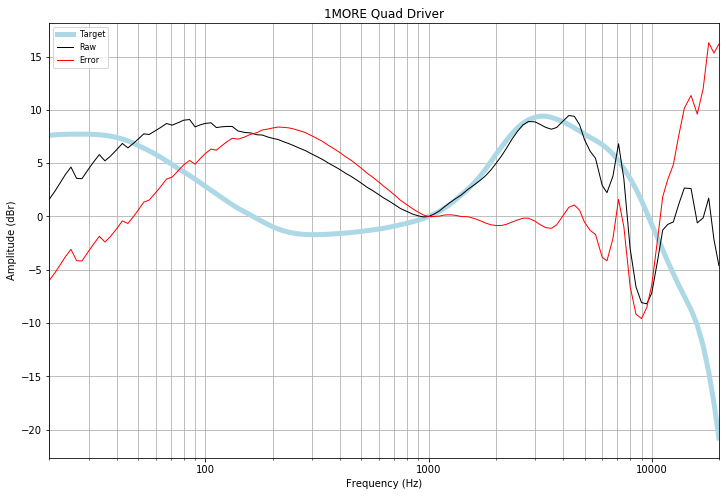

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bbc6047b88>)

In [94]:
fr = FrequencyResponse.read_from_csv(os.path.join(ROOT_DIR, 'measurements', 'oratory1990', 'data', 'inear', '1MORE Quad Driver', '1MORE Quad Driver.csv'))
fr.compensate(harman_ie)
fr.interpolate(HARMAN_INEAR_PREFENCE_FREQUENCIES)

delta = fr.error[np.where(fr.frequency == 500.0)[0][0]]
y = fr.error[np.logical_and(fr.frequency >= 40, fr.frequency <= 10000)] - delta
mean = np.mean(np.abs(y))

print(mean, delta)
fr.plot_graph()